# ***IMPORT DATASET***

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import statistics
from pandas.tseries.frequencies import to_offset

In [4]:
dataset_train = pd.read_csv('/content/BABA (1).csv', index_col=['Date'], parse_dates=['Date'])
dataset_train = dataset_train.resample('W').agg({'Open': 'mean', 
                               'High': 'max',
                               'Low': 'min',
                               'Close': 'mean',
                               'Adj Close': 'mean',
                               'Volume': 'mean'})
dataset_train = dataset_train.drop('Volume', axis=1)

train = dataset_train.iloc[:45,:]
test = dataset_train.iloc[46:,:]

In [5]:
dataset_train.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2021-12-12,122.800000,129.449997,113.430000,124.638001,124.638001
2021-12-19,121.673999,127.650002,117.769997,122.728000,122.728000
2021-12-26,117.309999,122.980003,113.695000,118.612501,118.612501
2022-01-02,116.344002,124.300003,110.379997,117.051999,117.051999
2022-01-09,122.282001,133.880005,115.769997,123.507999,123.507999


# ***PREPROCESSING DATA***

In [6]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(train)
print(training_set_scaled.shape)

(45, 5)


In [7]:
from statistics import mean
X_train = []
y_train = []
for i in range(5,45):
    X_train.append(training_set_scaled[i-5:i])
    y_train.append(training_set_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)

In [8]:
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1],X_train.shape[2]))
print(X_train.shape)

(40, 5, 5)


In [9]:
dataset_total = pd.concat((
    train, test), axis = 0)
print(dataset_total.shape)
inputs = dataset_total[len(dataset_total) -
                      len(test) - 5:].values
print(inputs.shape)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(5,12):
    X_test.append(inputs[i-5:i])
    y_test.append(inputs[i])
X_test = np.array(X_test)
y_test = np.array(y_test)
y_test = sc.inverse_transform(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],X_test.shape[2]))
print(X_test.shape)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
def to2dim(a):
  nsamples, nx, ny = a.shape
  a = a.reshape((nsamples,nx*ny))
  return a

(52, 5)
(12, 5)
(7, 5, 5)
(40, 5, 5) (40, 5) (7, 5, 5) (7, 5)


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


# ***RNN***

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dropout

In [11]:
RNN = Sequential()
RNN.add(SimpleRNN(units = 50, return_sequences = True,
                        input_shape = (X_train.shape[1], X_train.shape[2])))
RNN.add(SimpleRNN(units = 50, return_sequences = False))
RNN.add(Dense(units = 5))

RNN.compile(optimizer = 'adam', loss = 'mean_squared_error')

start_RNN = time.time()
RNN.fit(X_train, y_train, epochs = 5, batch_size = 32)
end_RNN =  time.time() - start_RNN

Epoch 1/5
2/2 [==============================] - 4s 15ms/step - loss: 0.4054
Epoch 2/5
2/2 [==============================] - 0s 14ms/step - loss: 0.0845
Epoch 3/5
2/2 [==============================] - 0s 18ms/step - loss: 0.1137
Epoch 4/5
2/2 [==============================] - 0s 23ms/step - loss: 0.1273
Epoch 5/5
2/2 [==============================] - 0s 14ms/step - loss: 0.0951


In [12]:
X_train_RNN = X_train[-1,-5:]
for i in range(7):
  a = np.array(X_train_RNN[-5:])
  a = np.reshape(a,(1,a.shape[0],a.shape[1]))
  predicted_RNN = RNN.predict(a)
  X_train_RNN = np.append(X_train_RNN,predicted_RNN,axis=0)
predicted_RNN = sc.inverse_transform(X_train_RNN[-7:])[:,0].reshape(-1,1)

1/1 [==============================] - 0s 27ms/step


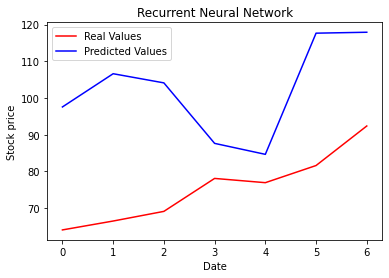

In [13]:
def plot_predictions(test, predicted, model_name):
    plt.plot(test, color="red", label="Real Values")
    plt.plot(predicted, color="blue", label="Predicted Values")
    plt.title(model_name)
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend()
    plt.show()
plot_predictions(y_test[:,0:1],predicted_RNN,'Recurrent Neural Network')

***RNN - Overfitting***

In [14]:
from keras.callbacks import EarlyStopping
earlyStop=EarlyStopping(monitor="val_loss")
RNN_DROP = Sequential()
RNN_DROP.add(SimpleRNN(units = 50, return_sequences = True,
                        input_shape = (X_train.shape[1], X_train.shape[2])))
RNN_DROP.add(Dropout(0.2))
RNN_DROP.add(SimpleRNN(units = 50, return_sequences = False))
RNN_DROP.add(Dropout(0.2))
RNN_DROP.add(Dense(units = 5))

RNN_DROP.compile(optimizer = 'adam', loss = 'mean_squared_error')

start_RNN = time.time()
RNN_DROP.fit(X_train, y_train, epochs = 5, batch_size = 32, callbacks=[earlyStop], validation_split=0.2)
end_RNN =  time.time() - start_RNN

Epoch 1/5
1/1 [==============================] - 4s 4s/step - loss: 0.4805 - val_loss: 0.0424
Epoch 2/5
1/1 [==============================] - 0s 52ms/step - loss: 0.3451 - val_loss: 0.0713


1/1 [==============================] - 0s 100ms/step


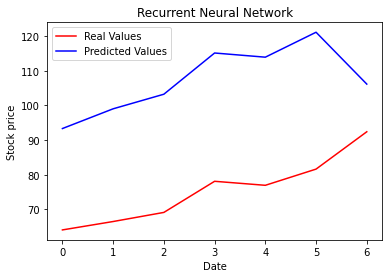

In [15]:
X_train_RNN_DROP = X_train[-1,-5:]
for i in range(7):
  a = np.array(X_train_RNN_DROP[-5:])
  a = np.reshape(a,(1,a.shape[0],a.shape[1]))
  predicted_RNN_DROP = RNN_DROP.predict(a)
  X_train_RNN_DROP = np.append(X_train_RNN_DROP,predicted_RNN_DROP,axis=0)
predicted_RNN_DROP = sc.inverse_transform(X_train_RNN_DROP[-7:])[:,0].reshape(-1,1)

plot_predictions(y_test[:,0:1],predicted_RNN_DROP,'Recurrent Neural Network')

# ***LSTM***

In [16]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1],X_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(5))

In [17]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
start_LSTM = time.time()
model.fit(X_train, y_train, batch_size=32, epochs=5)
end_LSTM =  time.time() - start_LSTM


Epoch 1/5
2/2 [==============================] - 5s 19ms/step - loss: 0.2550
Epoch 2/5
2/2 [==============================] - 0s 14ms/step - loss: 0.1581
Epoch 3/5
2/2 [==============================] - 0s 14ms/step - loss: 0.0851
Epoch 4/5
2/2 [==============================] - 0s 14ms/step - loss: 0.0530
Epoch 5/5
2/2 [==============================] - 0s 13ms/step - loss: 0.0618


In [18]:
X_train_LSTM = X_train[-1,-5:]
for i in range(7):
  a = np.array(X_train_LSTM[-5:])
  a = np.reshape(a,(1,a.shape[0],a.shape[1]))
  predicted_LSTM = model.predict(a)
  X_train_LSTM = np.append(X_train_LSTM,predicted_LSTM,axis=0)
predicted_LSTM = sc.inverse_transform(X_train_LSTM[-7:])[:,0].reshape(-1,1)

1/1 [==============================] - 0s 19ms/step


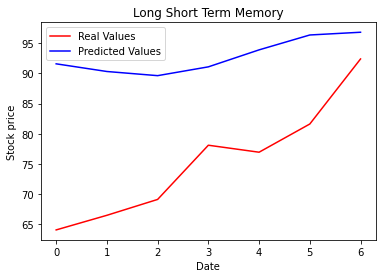

In [19]:
plot_predictions(y_test[:,0:1], predicted_LSTM, 'Long Short Term Memory')

***LTSM - Overfitting***

In [20]:
model_DROP = Sequential()
model_DROP.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1],X_train.shape[2])))
model_DROP.add(Dropout(0.2))
model_DROP.add(LSTM(64, return_sequences=False))
model_DROP.add(Dropout(0.2))
model_DROP.add(Dense(25))
model_DROP.add(Dropout(0.2))
model_DROP.add(Dense(5))
model_DROP.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
start_LSTM = time.time()
model_DROP.fit(X_train, y_train, batch_size=32, epochs=5, callbacks=[earlyStop], validation_split=0.2)
end_LSTM =  time.time() - start_LSTM


Epoch 1/5
1/1 [==============================] - 4s 4s/step - loss: 0.3133 - val_loss: 0.0385
Epoch 2/5
1/1 [==============================] - 0s 44ms/step - loss: 0.2695 - val_loss: 0.0308


1/1 [==============================] - 0s 18ms/step


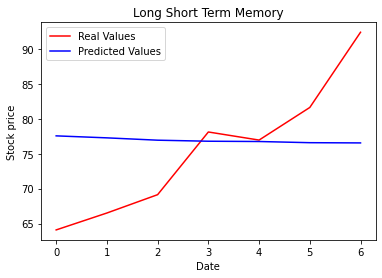

In [21]:
X_train_LSTM_DROP = X_train[-1,-5:]
for i in range(7):
  a = np.array(X_train_LSTM_DROP[-5:])
  a = np.reshape(a,(1,a.shape[0],a.shape[1]))
  predicted_LSTM_DROP = model_DROP.predict(a)
  X_train_LSTM_DROP = np.append(X_train_LSTM_DROP,predicted_LSTM_DROP,axis=0)
predicted_LSTM_DROP = sc.inverse_transform(X_train_LSTM_DROP[-7:])[:,0].reshape(-1,1)

plot_predictions(y_test[:,0:1], predicted_LSTM_DROP, 'Long Short Term Memory')

# ***MPL***

In [22]:
MLP = Sequential()
MLP.add(Dense(80, activation='relu'))
MLP.add(Dense(40, activation='relu'))
MLP.add(Dense(20, activation='relu'))
MLP.add(Dense(units = 5))
MLP.compile(loss='mean_squared_error', optimizer='adam')

In [23]:
start_MLP = time.time()
print(X_train.shape)
print(y_train.shape)
X_train_2dim = to2dim(X_train)
MLP.fit(X_train_2dim, y_train, batch_size=32, epochs=5)
end_MLP =  time.time() - start_MLP

(40, 5, 5)
(40, 5)
Epoch 1/5
2/2 [==============================] - 0s 16ms/step - loss: 0.2115
Epoch 2/5
2/2 [==============================] - 0s 8ms/step - loss: 0.1786
Epoch 3/5
2/2 [==============================] - 0s 9ms/step - loss: 0.1551
Epoch 4/5
2/2 [==============================] - 0s 8ms/step - loss: 0.1351
Epoch 5/5
2/2 [==============================] - 0s 7ms/step - loss: 0.1201


In [24]:
X_train_MLP = X_train_2dim[-1]
for i in range(7):
  a = np.array(X_train_MLP[-25:])
  a = np.reshape(a,(1,25))
  predicted_MLP = MLP.predict(a)
  X_train_MLP = np.append(X_train_MLP,predicted_MLP[0],axis=0)
predicted_MLP = sc.inverse_transform(np.array(X_train_MLP[-35:]).reshape(7,5))[:,0].reshape(-1,1)
print(predicted_MLP)


1/1 [==============================] - 0s 17ms/step
[[84.14994418]
 [81.99539631]
 [80.95490526]
 [80.71594043]
 [80.64415508]
 [80.07628933]
 [79.9366518 ]]


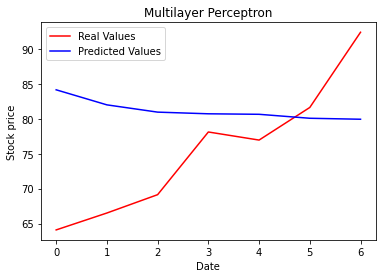

In [25]:
plot_predictions(y_test[:,0:1], predicted_MLP, 'Multilayer Perceptron')

***MLP - Overfitting***

In [26]:
MLP_DROP = Sequential()
MLP_DROP.add(Dense(80, activation='relu'))
MLP_DROP.add(Dropout(0.2))
MLP_DROP.add(Dense(40, activation='relu'))
MLP_DROP.add(Dropout(0.2))
MLP_DROP.add(Dense(20, activation='relu'))
MLP_DROP.add(Dropout(0.2))
MLP_DROP.add(Dense(units = 5))
MLP_DROP.compile(loss='mean_squared_error', optimizer='adam')

MLP_DROP.fit(X_train_2dim, y_train, batch_size=32, epochs=5, callbacks=[earlyStop], validation_split=0.2)

Epoch 1/5
1/1 [==============================] - 1s 638ms/step - loss: 0.3590 - val_loss: 0.0465
Epoch 2/5
1/1 [==============================] - 0s 36ms/step - loss: 0.3253 - val_loss: 0.0403


1/1 [==============================] - 0s 17ms/step


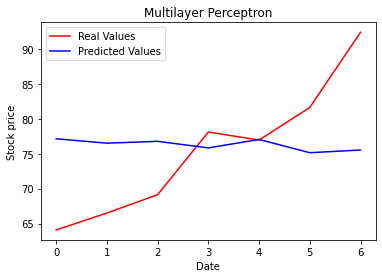

In [27]:
X_train_MLP_DROP = X_train_2dim[-1]
for i in range(7):
  a = np.array(X_train_MLP_DROP[-25:])
  a = np.reshape(a,(1,25))
  predicted_MLP_DROP = MLP_DROP.predict(a)
  X_train_MLP_DROP = np.append(X_train_MLP_DROP,predicted_MLP_DROP[0],axis=0)
predicted_MLP_DROP = sc.inverse_transform(np.array(X_train_MLP_DROP[-35:]).reshape(7,5))[:,0].reshape(-1,1)

plot_predictions(y_test[:,0:1], predicted_MLP_DROP, 'Multilayer Perceptron')

# ***SVR***

In [28]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

svr_rbf = MultiOutputRegressor(SVR(kernel= 'rbf', C= 50, gamma= 0.5))
start_SVR = time.time()
svr_rbf.fit(X_train_2dim, y_train)
end_SVR =  time.time() - start_SVR

In [29]:
X_train_SVR = X_train_2dim[-1]
for i in range(7):
  a = np.array(X_train_SVR[-25:])
  a = np.reshape(a,(1,25))
  predicted_SVR = svr_rbf.predict(a)
  X_train_SVR = np.append(X_train_SVR,predicted_SVR[0],axis=0)
predicted_SVR = sc.inverse_transform(np.array(X_train_SVR[-35:]).reshape(7,5))[:,0].reshape(-1,1)

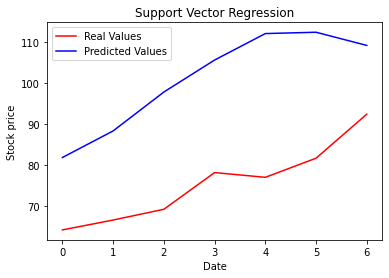

In [30]:
plot_predictions(y_test[:,0:1], predicted_SVR, 'Support Vector Regression')

# ***Random Forest***

In [31]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100, random_state = 0)
start_RF = time.time()
rf.fit(X_train_2dim, y_train)
end_RF =  time.time() - start_RF

In [32]:
X_train_RF = X_train_2dim[-1]
for i in range(7):
  a = np.array(X_train_RF[-25:])
  a = np.reshape(a,(1,25))
  predicted_RF = rf.predict(a)
  X_train_RF = np.append(X_train_RF,predicted_RF[0],axis=0)
predicted_RF = sc.inverse_transform(np.array(X_train_RF[-35:]).reshape(7,5))[:,0].reshape(-1,1)

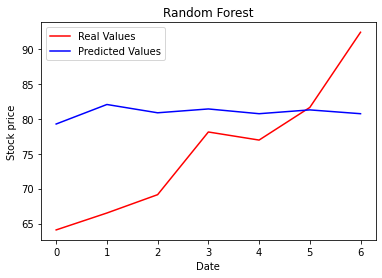

In [33]:
plot_predictions(y_test[:,0:1], predicted_RF, 'Random Forest')

# ***KNN***

In [34]:
from sklearn import neighbors

neighbor = neighbors.KNeighborsRegressor(n_neighbors = 1)
start_KNN = time.time()
neighbor.fit(X_train_2dim, y_train)
end_KNN =  time.time() - start_KNN

In [35]:
X_train_KNN = X_train_2dim[-1]
for i in range(7):
  a = np.array(X_train_KNN[-25:])
  a = np.reshape(a,(1,25))
  predicted_KNN = neighbor.predict(a)
  X_train_KNN = np.append(X_train_KNN,predicted_KNN[0],axis=0)
predicted_KNN = sc.inverse_transform(np.array(X_train_KNN[-35:]).reshape(7,5))[:,0].reshape(-1,1)

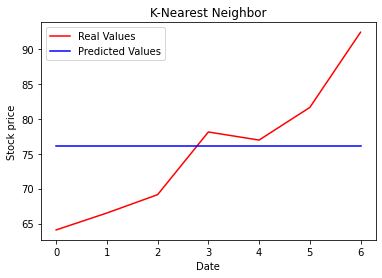

In [36]:
plot_predictions(y_test[:,0:1], predicted_KNN, 'K-Nearest Neighbor')

# ***Decision Tree***

In [37]:
from sklearn.tree import DecisionTreeRegressor

start_DT = time.time()
DT = DecisionTreeRegressor().fit(X_train_2dim, y_train)
end_DT =  time.time() - start_DT

In [38]:
X_train_DT = X_train_2dim[-1]
for i in range(7):
  a = np.array(X_train_DT[-25:])
  a = np.reshape(a,(1,25))
  predicted_DT = DT.predict(a)
  X_train_DT = np.append(X_train_DT,predicted_DT[0],axis=0)
predicted_DT = sc.inverse_transform(np.array(X_train_DT[-35:]).reshape(7,5))[:,0].reshape(-1,1)
print(predicted_DT)

[[76.0679994]
 [82.6559996]
 [76.0679994]
 [82.6559996]
 [76.0679994]
 [82.6559996]
 [76.0679994]]


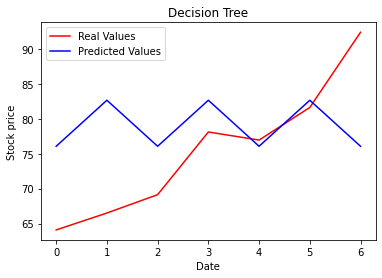

In [39]:
plot_predictions(y_test[:,0:1], predicted_DT, 'Decision Tree')

# ***Linear Regression***

In [40]:
from sklearn.linear_model import LinearRegression

start_LR = time.time()
LR = LinearRegression().fit(X_train_2dim, y_train)
end_LR =  time.time() - start_LR

In [41]:
X_train_LR = X_train_2dim[-1]
for i in range(7):
  a = np.array(X_train_LR[-25:])
  a = np.reshape(a,(1,25))
  predicted_LR = LR.predict(a)
  X_train_LR = np.append(X_train_LR,predicted_LR[0],axis=0)
predicted_LR = sc.inverse_transform(np.array(X_train_LR[-35:]).reshape(7,5))[:,0].reshape(-1,1)

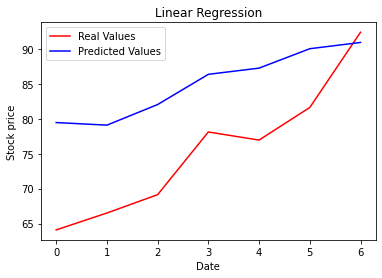

In [42]:
plot_predictions(y_test[:,0:1], predicted_LR, 'Linear Regression')

# ***LSTM + GRU***

In [43]:
from tensorflow.keras.layers import GRU

LSTM_GRU=Sequential()
LSTM_GRU.add(LSTM(32,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
LSTM_GRU.add(GRU(32))
LSTM_GRU.add(Dense(5))
LSTM_GRU.compile(loss='mean_squared_error',optimizer='adam')

In [44]:
start_LSTM_GRU = time.time()
LSTM_GRU.fit(X_train,y_train, epochs=5,batch_size=32)
end_LSTM_GRU =  time.time() - start_LSTM_GRU

Epoch 1/5
2/2 [==============================] - 4s 12ms/step - loss: 0.2912
Epoch 2/5
2/2 [==============================] - 0s 12ms/step - loss: 0.2546
Epoch 3/5
2/2 [==============================] - 0s 10ms/step - loss: 0.2201
Epoch 4/5
2/2 [==============================] - 0s 11ms/step - loss: 0.1914
Epoch 5/5
2/2 [==============================] - 0s 12ms/step - loss: 0.1637


In [45]:
X_train_LSTM_GRU = X_train[-1,-5:]
for i in range(7):
  a = np.array(X_train_LSTM_GRU[-5:])
  a = np.reshape(a,(1,a.shape[0],a.shape[1]))
  predicted_LSTM_GRU = LSTM_GRU.predict(a)
  X_train_LSTM_GRU = np.append(X_train_LSTM_GRU,predicted_LSTM_GRU,axis=0)
predicted_LSTM_GRU = sc.inverse_transform(X_train_LSTM_GRU[-7:])[:,0].reshape(-1,1)

1/1 [==============================] - 0s 18ms/step


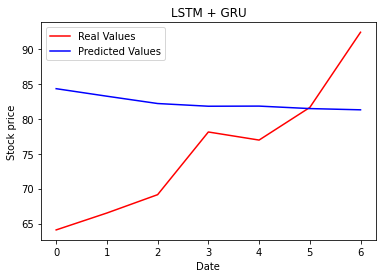

In [46]:
plot_predictions(y_test[:,0:1], predicted_LSTM_GRU, 'LSTM + GRU')

***LSTM + GRU - Overfitting***

In [47]:
LSTM_GRU_DROP=Sequential()
LSTM_GRU_DROP.add(LSTM(32,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
LSTM_GRU_DROP.add(Dropout(0.2))
LSTM_GRU_DROP.add(GRU(32))
LSTM_GRU_DROP.add(Dropout(0.2))
LSTM_GRU_DROP.add(Dense(5))
LSTM_GRU_DROP.compile(loss='mean_squared_error',optimizer='adam')

LSTM_GRU_DROP.fit(X_train,y_train, epochs=5,batch_size=32, callbacks=[earlyStop], validation_split=0.2)

Epoch 1/5
1/1 [==============================] - 4s 4s/step - loss: 0.2746 - val_loss: 0.0344
Epoch 2/5
1/1 [==============================] - 0s 36ms/step - loss: 0.2516 - val_loss: 0.0302


1/1 [==============================] - 0s 18ms/step


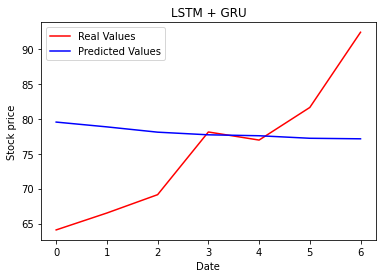

In [48]:
X_train_LSTM_GRU_DROP = X_train[-1,-5:]
for i in range(7):
  a = np.array(X_train_LSTM_GRU_DROP[-5:])
  a = np.reshape(a,(1,a.shape[0],a.shape[1]))
  predicted_LSTM_GRU_DROP = LSTM_GRU_DROP.predict(a)
  X_train_LSTM_GRU_DROP = np.append(X_train_LSTM_GRU_DROP,predicted_LSTM_GRU_DROP,axis=0)
predicted_LSTM_GRU_DROP = sc.inverse_transform(X_train_LSTM_GRU_DROP[-7:])[:,0].reshape(-1,1)

plot_predictions(y_test[:,0:1], predicted_LSTM_GRU_DROP, 'LSTM + GRU')

# ***MSE, MAE & R2 SCORE***

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 


print('----------RNN----------')
print("MSE: ", mean_squared_error(y_test[:,0:1],predicted_RNN))
print("MAE: ", mean_absolute_error(y_test[:,0:1],predicted_RNN))
print("R2 score:", r2_score(y_test[:,0:1], predicted_RNN))

print('----------LSTM----------')
print("MSE: ", mean_squared_error(y_test[:,0:1],predicted_LSTM))
print("MAE: ", mean_absolute_error(y_test[:,0:1],predicted_LSTM))
print("R2 score:", r2_score(y_test[:,0:1], predicted_LSTM))

print('----------MLP----------')
print("MSE: ", mean_squared_error(y_test[:,0:1],predicted_MLP))
print("MAE: ", mean_absolute_error(y_test[:,0:1],predicted_MLP))
print("R2 score:", r2_score(y_test[:,0:1], predicted_MLP))

print('----------SVR----------')
print("MSE: ", mean_squared_error(y_test[:,0:1],predicted_SVR))
print("MAE: ", mean_absolute_error(y_test[:,0:1],predicted_SVR))
print("R2 score:", r2_score(y_test[:,0:1], predicted_SVR))

print('----------RANDOM FOREST----------')
print("MSE: ", mean_squared_error(y_test[:,0:1],predicted_RF))
print("MAE: ", mean_absolute_error(y_test[:,0:1],predicted_RF))
print("R2 score:", r2_score(y_test[:,0:1], predicted_RF))

print('----------KNN----------')
print("MSE: ", mean_squared_error(y_test[:,0:1],predicted_KNN))
print("MAE: ", mean_absolute_error(y_test[:,0:1],predicted_KNN))
print("R2 score:", r2_score(y_test[:,0:1], predicted_KNN))

print('----------DECISION TREE----------')
print("MSE: ", mean_squared_error(y_test[:,0:1],predicted_DT))
print("MAE: ", mean_absolute_error(y_test[:,0:1],predicted_DT))
print("R2 score:", r2_score(y_test[:,0:1], predicted_DT))

print('----------LINEAR REGRESSION----------')
print("MSE: ", mean_squared_error(y_test[:,0:1],predicted_LR))
print("MAE: ", mean_absolute_error(y_test[:,0:1],predicted_LR))
print("R2 score:", r2_score(y_test[:,0:1], predicted_LR))

print('----------LSTM + GRU----------')
print("MSE: ", mean_squared_error(y_test[:,0:1],predicted_LSTM_GRU))
print("MAE: ", mean_absolute_error(y_test[:,0:1],predicted_LSTM_GRU))
print("R2 score:", r2_score(y_test[:,0:1], predicted_LSTM_GRU))

----------RNN----------
MSE:  864.7330517330904
MAE:  26.768070200786294
R2 score: -9.382833814624084
----------LSTM----------
MSE:  347.6862886969581
MAE:  17.26379700223797
R2 score: -3.174662860323032
----------MLP----------
MSE:  137.05400859628668
MAE:  9.663770474568949
R2 score: -0.6456049552301983
----------SVR----------
MSE:  690.5230624507163
MAE:  25.490619008634194
R2 score: -7.291097684102455
----------RANDOM FOREST----------
MSE:  109.95813645872916
MAE:  8.785041039142856
R2 score: -0.32026531786729207
----------KNN----------
MSE:  83.55631821248771
MAE:  7.609285599999997
R2 score: -0.003259172785599729
----------DECISION TREE----------
MSE:  105.83504827385903
MAE:  8.261285285714285
R2 score: -0.2707594740224797
----------LINEAR REGRESSION----------
MSE:  115.40674076989917
MAE:  9.895490116253173
R2 score: -0.3856866094105511
----------LSTM + GRU----------
MSE:  145.57696769921012
MAE:  9.971061246133766
R2 score: -0.7479399680958865


# ***TRANING TIME***

In [50]:
print('RNN:',end_RNN)
print('LTSM:',end_LSTM)
print('MLP:',end_MLP)
print('SVR:',end_SVR)
print('RANDOM FOREST:',end_RF)
print('KNN:',end_KNN)
print('DECISION TREE:',end_DT)
print('LINEAR REGRESSION:',end_LR)
print('LSTM + GRU:', end_LSTM_GRU)

RNN: 4.10901665687561
LTSM: 4.021567344665527
MLP: 0.6269762516021729
SVR: 0.004752159118652344
RANDOM FOREST: 0.14252591133117676
KNN: 0.0006067752838134766
DECISION TREE: 0.0026547908782958984
LINEAR REGRESSION: 0.021271228790283203
LSTM + GRU: 3.950535535812378


# ***COMPARE MODELS***

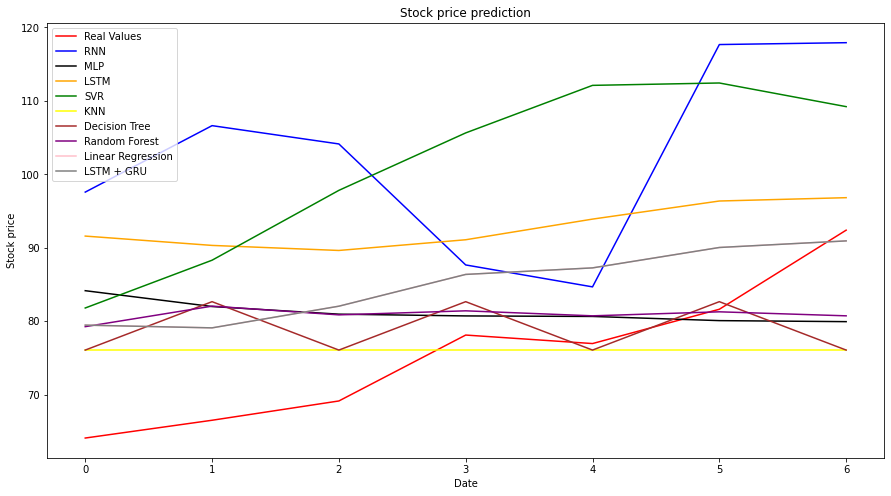

In [51]:
plt.figure(figsize=(15,8))
plt.plot(y_test[:,0:1], color="red", label="Real Values")
plt.plot(predicted_RNN, color="blue", label="RNN")
plt.plot(predicted_MLP, color="black", label="MLP")
plt.plot(predicted_LSTM, color="orange", label="LSTM")
plt.plot(predicted_SVR, color="green", label="SVR")
plt.plot(predicted_KNN, color="yellow", label="KNN")
plt.plot(predicted_DT, color="brown", label="Decision Tree")
plt.plot(predicted_RF, color="purple", label="Random Forest")
plt.plot(predicted_LR, color="pink", label="Linear Regression")
plt.plot(predicted_LR, color="gray", label="LSTM + GRU")
plt.title('Stock price prediction')
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend()
plt.show()